# Titanic Survival Prediction

### *Business Goal: Build a model to predict if a passenger will survive on the titanic disaster*

## Import packages/libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score

## Get and load the data

In [2]:
test = pd.read_csv('../data/test.csv', sep=',')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
test.shape

(418, 11)

# Exploratory Data Analysis

* the number of survived/non-survived passengers

* *From the left graph, most of dead are in Pclass 3. From the right graph, we found that females survived more than males*

## Check whether the column is binary, categorical or metric.

In [4]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


* *We need to convert a lot of features into numeric ones. The test-set has 418 examples and 11 features + the target variable (survived). 2 of the features are floats, 5 are integers and 5 are objects.*


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
# Getting the Categorical and Numerical Features
test['Pclass'].dtypes, test['Sex'].dtypes

(dtype('int64'), dtype('O'))

In [7]:
numerical_features = [x for x in test.columns if test[x].dtypes != 'O']
categorical_features = [x for x in test.columns if test[x].dtypes == 'O']

In [8]:
numerical_features, categorical_features

(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'],
 ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'])

## Check whether the column contains any missing values.

<AxesSubplot:>

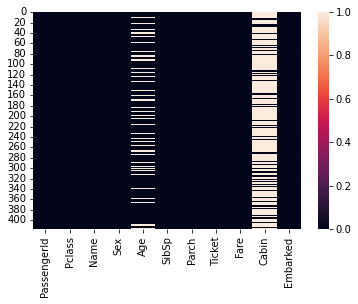

In [9]:
sns.heatmap(test.isnull())

* *From above heatmap, we can see that there are NULL/NaN values present in the dataset. On the below, here are the number of null values Before we start with the Analysis, we need to process this data and then proceed with the analysis*
* *The Fare feature has only 1 missing values, which can easily be filled. It will be much more tricky, to deal with the ‘Age’ feature, which has 86 missing values. The ‘Cabin’ feature needs further investigation, but it looks like that we might want to drop it from the dataset, since 78 % of it are missing.*

In [10]:
test.isna().sum()


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### Name, Passenger ID & Ticket

* *Name, PassengerID and Ticket are not important columns and can be dropped*

In [11]:
test.drop(['Name'],axis = 1, inplace = True)
categorical_features.remove('Name')

In [12]:
test.drop(['PassengerId'], axis = 1, inplace = True)
numerical_features.remove('PassengerId')

In [13]:
test.drop(['Ticket'], axis = 1, inplace = True)
categorical_features.remove('Ticket')

### Cabin

* *Cabin column has more null values and there are so many unique values that's why I dropped*

In [14]:
test[['Cabin']].describe()

,Cabin
count,91
unique,76
top,B57 B59 B63 B66
freq,3


In [15]:
test.drop(['Cabin'],axis = 1,inplace = True)
categorical_features.remove('Cabin')

In [16]:
numerical_features, categorical_features

(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], ['Sex', 'Embarked'])

### Age & Sex

* *The below histogram clears that the data is normally distributed, and so we would be using mean for NULL values*

* *I applied mean value of age group by Sex(male/female passengers)*

In [17]:
test['Age'] = test['Age'].fillna(test.groupby([ 'Sex'])['Age'].transform('mean'))
test.head(6)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S
5,3,male,14.0,0,0,9.2250,S


In [18]:
test['Age'].isna().sum()

0

### Fare

In [19]:
test['Fare'].fillna(35.6271884892086, inplace = True)

In [20]:
test['Fare'].isna().sum()

0

# Feature Engineering

### Age

* *I appied it to divided 5 age groups. *


In [21]:
test['Age'].describe()

count    418.000000
mean      30.272597
std       12.634534
min        0.170000
25%       23.000000
50%       30.272362
75%       35.750000
max       76.000000
Name: Age, dtype: float64

In [22]:
kbins = KBinsDiscretizer(n_bins=5, encode='onehot-dense', strategy='quantile')

In [23]:
columns_age = test[['Age']]

In [24]:
kbins.fit(columns_age)

KBinsDiscretizer(encode='onehot-dense')

In [25]:
t_age = kbins.transform(columns_age)
t_age.shape

(418, 5)

In [26]:
edges_age = kbins.bin_edges_[0].round(4)
edges_age

array([ 0.17  , 21.    , 27.8   , 30.2727, 39.    , 76.    ])

In [27]:
labels_age = []
for i in range(len(edges_age)-1):
    edge1 = edges_age[i]
    edge2 = edges_age[i+1]
    labels_age.append(f"{edge1}_to_{edge2}")

# create a DataFrame
Age_t = pd.DataFrame(t_age, columns=labels_age)
Age_t.head()

,0.17_to_21.0,21.0_to_27.8,27.8_to_30.2727,30.2727_to_39.0,39.0_to_76.0
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0


### Sex

In [28]:
ohc = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [29]:
cols_sex = test[['Sex']]

In [30]:
ohc.fit(cols_sex)

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [31]:
t_sex = ohc.transform(cols_sex)
t_sex.shape

(418, 2)

In [32]:
Sex_t = pd.DataFrame(t_sex, columns=ohc.get_feature_names())
Sex_t.head()

,x0_female,x0_male
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,1.0,0.0


In [33]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


### Embarked

* *Port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)*

In [34]:
ohc = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [35]:
cols_embarked = test[['Embarked']]

In [36]:
ohc.fit(cols_embarked)

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [37]:
t_embarked = ohc.transform(cols_embarked)
t_embarked.shape

(418, 3)

In [38]:
Embarked_t = pd.DataFrame(t_embarked, columns=ohc.get_feature_names())
Embarked_t.head()

,x0_C,x0_Q,x0_S
0,0.0,1.0,0.0
1,0.0,0.0,1.0
2,0.0,1.0,0.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


### Fare

* *Passenger fare (British pound)*
* *I appied it to divided 4 fare groups.*

In [39]:
kbins = KBinsDiscretizer(n_bins=4, encode='onehot-dense', strategy='quantile')

In [40]:
columns_fare = test[['Fare']]

In [41]:
kbins.fit(columns_fare)

KBinsDiscretizer(encode='onehot-dense', n_bins=4)

In [42]:
t_fare = kbins.transform(columns_fare)
t_fare.shape

(418, 4)

In [43]:
edges_fare = kbins.bin_edges_[0].round(4)
edges_fare

array([  0.    ,   7.8958,  14.4542,  31.5   , 512.3292])

In [44]:
labels_fare = []
for i in range(len(edges_fare)-1):
    edge1 = edges_fare[i]
    edge2 = edges_fare[i+1]
    labels_fare.append(f"{edge1}_to_{edge2}")

# create a DataFrame
Fare_t = pd.DataFrame(t_fare, columns=labels_fare)
Fare_t.head()

,0.0_to_7.8958,7.8958_to_14.4542,14.4542_to_31.5,31.5_to_512.3292
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0


### SibSp & Parch

* *sibsp: Number of siblings/spouses aboard*
* *parch: Number of parents/children aboard*
* *I created a new column 'Alone' and then if one of them is greater than 1 write 0; otherwise write 1*

In [45]:
test['SibSp_Parch']=test['SibSp']+test['Parch']+1 #1 is person him/herself

In [46]:
test['Alone']=0
test.loc[test.SibSp_Parch==1, 'Alone'] = 1

In [47]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,SibSp_Parch,Alone
0,3,male,34.5,0,0,7.8292,Q,1,1
1,3,female,47.0,1,0,7.0000,S,2,0
2,2,male,62.0,0,0,9.6875,Q,1,1
3,3,male,27.0,0,0,8.6625,S,1,1
4,3,female,22.0,1,1,12.2875,S,3,0


# Transforming the train data 

In [48]:
test=pd.concat([test, Age_t, Sex_t, Embarked_t, Fare_t ], axis=1)

In [49]:
test.drop(['Sex', 'Age', 'Embarked', 'SibSp','Parch', 'SibSp_Parch', 'Fare' ], axis=1, inplace=True)

In [50]:
test.head()

,Pclass,Alone,0.17_to_21.0,21.0_to_27.8,27.8_to_30.2727,30.2727_to_39.0,39.0_to_76.0,x0_female,x0_male,x0_C,x0_Q,x0_S,0.0_to_7.8958,7.8958_to_14.4542,14.4542_to_31.5,31.5_to_512.3292
0,3,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,3,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,2,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,3,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,3,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [72]:
test.shape

(418, 17)

In [74]:
test.to_csv('../data/test_1.csv')